The following is our team's repository of data analysis and model development for Smoke detection using GOES satellite.

# Installation and Import of Modules and Dataset

In [88]:
!pip install Pillow
!pip install rasterio
!pip install segmentation_models
!pip install mat4py
!apt install octave

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
octave is already the newest version (5.2.0-1).
0 upgraded, 0 newly installed, 0 to remove and 22 not upgraded.


In [89]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)
import tensorflow as tf
import cv2
import os,re
import rasterio
from random import randint
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from rasterio.plot import show, show_hist
from keras.layers import Input
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import sys,traceback
from mat4py import savemat

Mounted at /content/drive/


In [90]:
tifpath = "/content/drive/MyDrive/dataset/images/"
bmppath = "/content/drive/MyDrive/dataset/mask/"
bmpfol = []
tiffol=[]
for image in os.listdir(tifpath):
    tiffol.append(image)
for _ in os.listdir(bmppath):
    bmpfol.append(_)

tiffol = sorted(tiffol)
bmpfol=sorted(bmpfol)
print('Instances of Mask Dataset:',len(bmpfol))
print('\nInstances of Raster Image Dataset:',len(tiffol))

Instances of Mask Dataset: 352

Instances of Raster Image Dataset: 352


# Visualisation of Images

In [91]:
bmpd = bmppath + bmpfol[28]
tifd = tifpath + tiffol[28]
print("Sample .bmp file directory:\n",bmpd,"\n")
print("Sample .tif file directory:\n",tifd,"\n")

Sample .bmp file directory:
 /content/drive/MyDrive/dataset/mask/time-20171161915394-loc--111.6_34.3_-110.8_34.9.bmp 

Sample .tif file directory:
 /content/drive/MyDrive/dataset/images/time-20171161915394-loc--111.6_34.3_-110.8_34.9.tif 



In [92]:
srb = rasterio.open(bmpd)
#Rasterio Color Interpretation of .bmp Image
print("Rasterio Colormap object created for .bmp file:\n",srb.colormap,"\n\nRasterio ColorInterp object created for .bmp file:\n",srb.colorinterp)

Rasterio Colormap object created for .bmp file:
 <built-in method colormap of DatasetReader object at 0x7f502b94eb40> 

Rasterio ColorInterp object created for .bmp file:
 (<ColorInterp.palette: 2>,)


/usr/local/lib/python3.9/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Width:60, Height:55



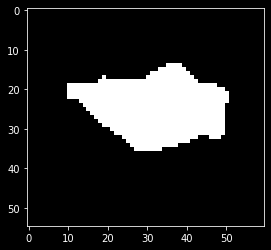

In [93]:
plt.imshow(srb.read(1), cmap='gray')
print(f"Width:{srb.width}, Height:{srb.height}\n")
plt.show()

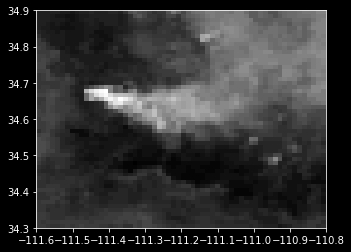

(<ColorInterp.gray: 1>, <ColorInterp.undefined: 0>, <ColorInterp.undefined: 0>, <ColorInterp.undefined: 0>, <ColorInterp.undefined: 0>, <ColorInterp.undefined: 0>)
<built-in method colormap of DatasetReader object at 0x7f502b94ed40>


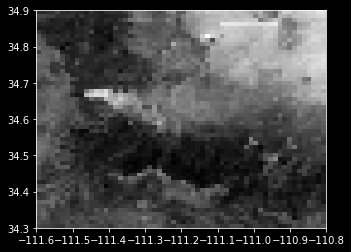

(<ColorInterp.gray: 1>, <ColorInterp.undefined: 0>, <ColorInterp.undefined: 0>, <ColorInterp.undefined: 0>, <ColorInterp.undefined: 0>, <ColorInterp.undefined: 0>)
<built-in method colormap of DatasetReader object at 0x7f502b94ed40>


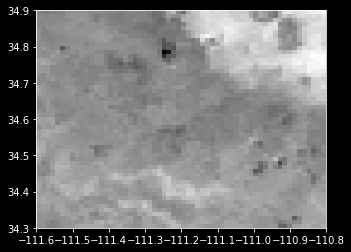

(<ColorInterp.gray: 1>, <ColorInterp.undefined: 0>, <ColorInterp.undefined: 0>, <ColorInterp.undefined: 0>, <ColorInterp.undefined: 0>, <ColorInterp.undefined: 0>)
<built-in method colormap of DatasetReader object at 0x7f502b94ed40>


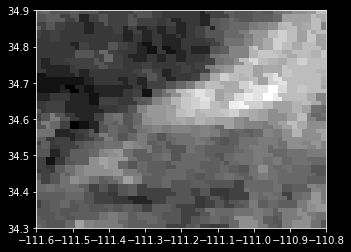

(<ColorInterp.gray: 1>, <ColorInterp.undefined: 0>, <ColorInterp.undefined: 0>, <ColorInterp.undefined: 0>, <ColorInterp.undefined: 0>, <ColorInterp.undefined: 0>)
<built-in method colormap of DatasetReader object at 0x7f502b94ed40>


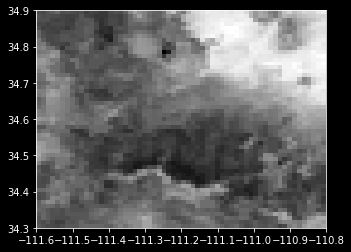

(<ColorInterp.gray: 1>, <ColorInterp.undefined: 0>, <ColorInterp.undefined: 0>, <ColorInterp.undefined: 0>, <ColorInterp.undefined: 0>, <ColorInterp.undefined: 0>)
<built-in method colormap of DatasetReader object at 0x7f502b94ed40>


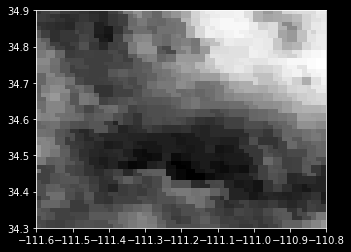

(<ColorInterp.gray: 1>, <ColorInterp.undefined: 0>, <ColorInterp.undefined: 0>, <ColorInterp.undefined: 0>, <ColorInterp.undefined: 0>, <ColorInterp.undefined: 0>)
<built-in method colormap of DatasetReader object at 0x7f502b94ed40>


In [125]:
srt = rasterio.open(tifd)
for _ in range(1,7):
  try:
    show(srt.read(_),transform=srt.transform,cmap='gray')
    print(srt.colorinterp)
    print(srt.colormap)
  except IndexError:
    break

# Exploratory Data Analysis

## Reading data and metadata

In [95]:
srt.descriptions #No descriptions given on the rasters

(None, None, None, None, None, None)

In [96]:
#Tagged Raster Image into N-Dimensional Array
tifa = srt.read()
meta = srt.meta
print("Matrix Representation of .tif image:\n")
print(tifa,"\n\nDatatype:",tifa.dtype)
print("\nMatrix Shape:",tifa.shape)

Matrix Representation of .tif image:

[[[ 85  85  85 ... 101 103 103]
  [ 85  85  85 ... 101 102 102]
  [ 85  85  85 ... 100 102 103]
  ...
  [ 90  90  89 ...  87  89  89]
  [ 90  89  90 ...  89  89  87]
  [ 90  90  89 ...  89  87  88]]

 [[ 73  72  74 ... 112 116 116]
  [ 80  80  78 ... 112 113 114]
  [ 77  76  73 ... 107 109 110]
  ...
  [ 81  85  81 ...  80  86  80]
  [ 82  80  80 ...  83  83  78]
  [ 80  78  78 ...  83  80  83]]

 [[115 113 113 ... 137 138 139]
  [116 116 115 ... 134 132 135]
  [116 116 116 ... 131 132 134]
  ...
  [118 119 118 ... 122 122 122]
  [118 118 116 ... 123 122 121]
  [118 118 115 ... 121 121 123]]

 [[ 16  17  17 ...  22  26  26]
  [ 15  15  16 ...  26  24  24]
  [ 15  15  16 ...  26  26  24]
  ...
  [ 16  15  15 ...  19  18  18]
  [ 16  16  15 ...  18  18  15]
  [ 17  16  15 ...  18  18  15]]

 [[104 103 106 ... 140 144 146]
  [106 104 105 ... 138 140 140]
  [105 105 105 ... 135 138 142]
  ...
  [106 111 108 ... 123 129 129]
  [106 104 107 ... 128 127 1

In [97]:
bmpa = np.array(srb.read())
print("Matrix Shape:",bmpa.shape)
print("Matrix Representation of .bmp file\n")
bmpa = np.array(srb.read(1))
#Bitmap Image into N-Dimensional array
print(bmpa,"\n\nDatatype:",bmpa.dtype)
print("\nMatrix Shape:",bmpa.shape)

Matrix Shape: (1, 55, 60)
Matrix Representation of .bmp file

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]] 

Datatype: uint8

Matrix Shape: (55, 60)


In [98]:
meta #Metadata of .tif Image

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': 0.0,
 'width': 60,
 'height': 55,
 'count': 6,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(0.013333333333333286, 0.0, -111.6,
        0.0, -0.010909090909090934, 34.9)}

## Raster Histogram

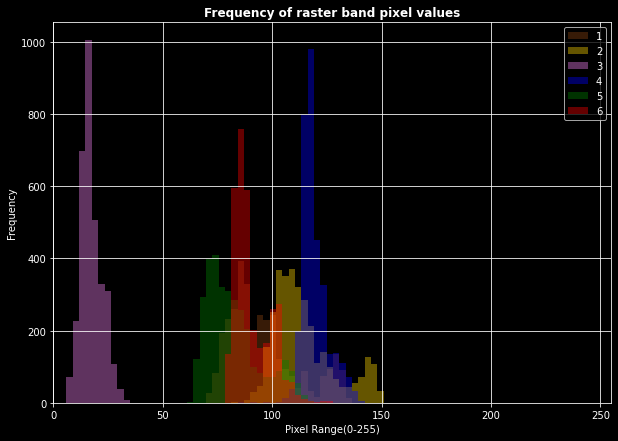

In [99]:
(axrgb, axhist) = plt.subplots(1, 1, figsize=(10,7))
show_hist(
    tifa, bins=50, lw=0.0, stacked=False, alpha=0.4,
    histtype='stepfilled', title="Frequency of raster band pixel values",ax=axhist)
plt.xlim(xmin=0, xmax = 255)
plt.xlabel("Pixel Range(0-255)")
plt.legend(['1','2','3','4','5','6'])
plt.show()

The third raster seems to stand out from the other five rasters and the fourth raster also shows some level of promise.

## File Description using Matlab

In [100]:
#Upload nasameta.m and show the .tif image's description
%%writefile

UsageError: %%writefile is a cell magic, but the cell body is empty.


In [ ]:
!octave -W nasameta.m

# Feature Engineering

## Complete Conversion of Dataset

In [101]:
Y = []
for path in bmpfol:
  imgy = cv2.imread(os.path.join(bmppath,path))
  Y.append(imgy)

In [ ]:
X = []
for path in tiffol:
  with rasterio.open(os.path.join(tifpath,path)) as srt:
    imgx = srt.read()
    print("Raster Image Metadata",srt.meta,'\n')
  X.append(imgx)

In [ ]:
for i in range(0,len(X)):
  print("Shape of Raster Image:",X[i].shape)
  print("Shape of Mask Image",Y[i].shape,'\n')

## Dataframe representation of image dimensions

In [104]:
rastcols = ['TiffHeight','TiffWidth','BmpHeight','BmpWidth']
rastframe = pd.DataFrame(columns = rastcols)
for i in range(0,len(X)):
    rastframe.loc[len(rastframe.index)]=[X[i].shape[1],X[i].shape[2],Y[i].shape[0],Y[i].shape[1]]
rastframe

,TiffHeight,TiffWidth,BmpHeight,BmpWidth
0,397,352,397,352
1,55,47,55,47
2,46,52,46,52
3,231,167,231,167
4,83,82,83,82
5,258,237,258,237
6,305,286,305,286
7,212,132,212,132
8,46,37,46,37
9,166,185,166,185


In [105]:
print("Maximum .tif Height =",rastframe['TiffHeight'].max(),"\nMaximum .tif Width = ",rastframe['TiffWidth'].max())

Maximum .tif Height = 1572 
Maximum .tif Width =  7080


In [106]:
print("Minimum .tif Height =",rastframe['TiffHeight'].min(),"\nMinimum .tif Width = ",rastframe['TiffWidth'].min())

Minimum .tif Height = 18 
Minimum .tif Width =  21


In [107]:
print("Maximum .bmp height =",rastframe['BmpHeight'].max(),"\nMaximum .bmp Width = ",rastframe['BmpWidth'].max())

Maximum .bmp height = 1572 
Maximum .bmp Width =  7080


In [108]:
print("Minimum .bmp Height =",rastframe['BmpHeight'].min(),"\nMinimum .bmp Width = ",rastframe['BmpWidth'].min())

Minimum .bmp Height = 18 
Minimum .bmp Width =  21


In [109]:
tifframe = rastframe.loc[:,['TiffHeight','TiffWidth']]

In [110]:
bmpframe = rastframe.loc[:,['BmpHeight','BmpWidth']]

In [111]:
tifframe[tifframe.duplicated(subset=['TiffHeight','TiffWidth'])]

,TiffHeight,TiffWidth
99,83,82
110,46,52
133,27,31
135,83,86
148,83,82
198,83,77
204,92,76
213,73,60
219,55,76
222,129,127


In [112]:
tifframe[tifframe.duplicated(subset=['TiffHeight','TiffWidth'])].count()

TiffHeight    14
TiffWidth     14
dtype: int64

In [113]:
bmpframe[bmpframe.duplicated(subset=['BmpHeight','BmpWidth'])]

,BmpHeight,BmpWidth
99,83,82
110,46,52
133,27,31
135,83,86
148,83,82
198,83,77
204,92,76
213,73,60
219,55,76
222,129,127


In [114]:
bmpframe[bmpframe.duplicated(subset=['BmpHeight','BmpWidth'])].count()

BmpHeight    14
BmpWidth     14
dtype: int64

This means there are some images with a common pattern of pixel dimensions,however, this is too few a quantity of images to set a standard for pixel dimension.

## Ideas and Brainstorming

* Our issue upto this point is one of dimensionality, pixel dimensions and their inconsistency. We have to figure out a way to transform the dimensions in such a manner that can be effectively used for training while maintaining integrity of image data.<br><br>
* Do we need to scale/resize the images? How far would it affect integrity?? Should we apply a transform function or convert the data into a different interactive format??
<br><br>
* Should we identify what each raster tracks?? The wavelength range of each raster??<br><br>
* What type of model should we try? Would utilizing a model such as U-Net be sufficient??


### Idea 1: Conversion to Npy format and reshaping

In [ ]:
#npy converted images
tifpypat = "/content/drive/MyDrive/numpy/images/"
bmppypat = "/content/drive/MyDrive/numpy/masks/"
bmppyfol = []
tifpyfol=[]
for image in os.listdir(tifpypat):
    tifpyfol.append(image)
for _ in os.listdir(bmppypat):
  bmppyfol.append(_)
tifpyfol=sorted(tifpyfol)
bmppyfol = sorted(bmppyfol)

In [ ]:
np.load(os.path.join(tifpypat,tifpyfol[28]))

array([[[0.33333333, 0.33333333, 0.33333333, ..., 0.40238205,
         0.40238205, 0.40238205],
        [0.33333333, 0.33333333, 0.33333333, ..., 0.40322457,
         0.40322457, 0.40322457],
        [0.33333333, 0.33333333, 0.33333333, ..., 0.40377604,
         0.40377604, 0.40377604],
        ...,
        [0.35288547, 0.35291957, 0.35292867, ..., 0.34465302,
         0.34443521, 0.34361842],
        [0.35267436, 0.35283772, 0.35288128, ..., 0.34424373,
         0.34412932, 0.34370027],
        [0.35235183, 0.35271265, 0.35280887, ..., 0.34361842,
         0.34366198, 0.34382534]],

       [[0.29613929, 0.29669758, 0.29684646, ..., 0.45169061,
         0.45159439, 0.45123357],
        [0.28991909, 0.29067485, 0.29087638, ..., 0.45344807,
         0.45340451, 0.45324115],
        [0.28584768, 0.28673269, 0.28696869, ..., 0.4545984 ,
         0.45458931, 0.4545552 ],
        ...,
        [0.31101409, 0.31285233, 0.31334252, ..., 0.32385158,
         0.32318905, 0.32070456],
        [0.3

In [ ]:
np.load(os.path.join(bmppypat,bmppyfol[28])).shape

(1, 256, 256)

In [ ]:
np.load(os.path.join(bmppypat,bmppyfol[28])).shape

(1, 256, 256)

In [ ]:
Xpy = []
for path in tifpyfol:
  imgpx = np.load(os.path.join(tifpypat,path)).reshape(256,256,6)
  imgpx = imgpx[:,:,0]
  Xpy.append(imgpx)

In [ ]:
Ypy = []
for path in bmppyfol:
  imgpy = np.load(os.path.join(bmppypat,path))
  Ypy.append(imgy)

In [ ]:
Xpy[28].shape

(256, 256)

In [ ]:
Ypy[28].shape

(117, 87, 3)

Hence reshaping using npy array method does not work..

### Idea 2: Utilizing Rasterio Resampling function

In [ ]:
#scaling function to 512x512
from rasterio.enums import Resampling
with rasterio.open('/content/drive/MyDrive/dataset/images/time-20170652036101-loc--102.0_35.2_-97.2_39.5.tif') as trial:
    data = trial.read()
    profile = trial.profile
    scale_factor = 512.0 / max(data.shape[1], data.shape[2])
    new_height = int(data.shape[1] * scale_factor)
    new_width = int(data.shape[2] * scale_factor)
    resized_data = trial.read(out_shape=(data.shape[0], new_height, new_width), resampling=Resampling.bilinear)
    profile.update({'height': new_height, 'width': new_width})

    # Pad the output image to make it square (512x512)
    pad_height = max(0, 512 - new_height)
    pad_width = max(0, 512 - new_width)
    pad_top = pad_height // 2
    pad_bottom = pad_height - pad_top
    pad_left = pad_width // 2
    pad_right = pad_width - pad_left
    resized_data = np.pad(resized_data, ((0, 0), (pad_top, pad_bottom), (pad_left, pad_right)), mode='reflect')
    profile.update({'height': 512, 'width': 512})

    with rasterio.open('output2.tif', 'w', **profile) as dst:
        dst.write(resized_data)

In [ ]:
with rasterio.open('output2.tif','r') as blerr:
  data = blerr.read()
data

In [ ]:
data.shape

In [ ]:
srt = rasterio.open('output2.tif')
for _ in range(1,7):
  try:
    show(srt.read(_),transform=srt.transform,cmap='gray')
    print(srt.colorinterp)
    print(srt.colormap)
  except IndexError:
    break

So with the Rasterio resampling function, we can resize the image to (6,512,512), however mere extension of images is causing some level of distortion and data from feature is lost.

### Idea 3: Principle Component Analysis

#### Reshaping and Scaling

In [117]:
# Reshape the raster data into a 2D array
X = np.stack(tifa).reshape(len(tifa), -1).T
# Scale the data
X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
'''
# Sort the eigenvalues and eigenvectors in descending order
eigenvalues_sorted = pca.explained_variance_[::-1]
eigenvectors_sorted = pca.components_[::-1]

# Select the top k eigenvectors
k = 2
selected_eigenvectors = eigenvectors_sorted[:k]

# Project the data onto the selected eigenvectors
X_pca = np.dot(X, selected_eigenvectors.T)
plt.show()'''

'\n# Sort the eigenvalues and eigenvectors in descending order\neigenvalues_sorted = pca.explained_variance_[::-1]\neigenvectors_sorted = pca.components_[::-1]\n\n# Select the top k eigenvectors\nk = 2\nselected_eigenvectors = eigenvectors_sorted[:k]\n\n# Project the data onto the selected eigenvectors\nX_pca = np.dot(X, selected_eigenvectors.T)\n\n# Visualize the results\nimport matplotlib.pyplot as plt\nfig, ax = plt.subplots()\nax.scatter(X_pca[:, 0], X_pca[:, 1])\nax.set_xlabel("PC1")\nax.set_ylabel("PC2")\nplt.show()'

#### Dataframe Representation of Reshaped, Scale Array

In [116]:
pd.set_option("display.max_rows",100)
pd.DataFrame(X)

,0,1,2,3,4,5
0,-0.728966,-0.747488,-0.775336,-0.222496,-0.747705,-0.759446
1,-0.728966,-0.828657,-1.123849,-0.027220,-0.819024,-0.568562
2,-0.728966,-0.666320,-1.123849,-0.027220,-0.605066,-0.568562
3,-0.728966,-0.666320,-0.949592,-0.417772,-0.462428,-0.441307
4,-0.728966,-0.260477,-0.949592,-0.417772,-0.248471,-0.441307
...,...,...,...,...,...,...
3295,-0.347490,-0.179309,0.618716,0.753884,0.678676,0.258599
3296,-0.220331,0.064197,0.792973,0.753884,0.963953,0.258599
3297,-0.220331,0.064197,0.270203,0.168056,0.821314,0.513110
3298,-0.474648,-0.179309,0.270203,0.168056,0.678676,0.513110


#### SVD PCA fitting

In [118]:
pca=PCA()
pca.fit(X)

PCA()

#### Analysis of Components

In [119]:
print(pca.singular_values_,"\n")
print(pca.components_)
print("\n",pca.explained_variance_,"\n")
print(pca.components_.shape)

[116.25382331  52.92780502  47.45079055  31.02897989  13.07832845
   9.91353772] 

[[ 0.40144958  0.47284676  0.33942686  0.26013209  0.46676061  0.4631516 ]
 [ 0.33710613 -0.03696857 -0.40609107  0.79880823 -0.21702622 -0.1867829 ]
 [ 0.45723946  0.24434238 -0.68411576 -0.49750677  0.01002702  0.12490389]
 [ 0.55622836  0.15863507  0.48333073 -0.20305913 -0.40557643 -0.47551138]
 [-0.44837716  0.81184682 -0.08129044  0.07409449 -0.35077068 -0.06873468]
 [-0.07548309  0.17631142 -0.10792749  0.0008456   0.66888063 -0.71004664]]

 [4.09668125 0.84915203 0.68250304 0.29184528 0.05184682 0.02979031] 

(6, 6)


In [120]:
pca.components_[::-1]

array([[-0.07548309,  0.17631142, -0.10792749,  0.0008456 ,  0.66888063,
        -0.71004664],
       [-0.44837716,  0.81184682, -0.08129044,  0.07409449, -0.35077068,
        -0.06873468],
       [ 0.55622836,  0.15863507,  0.48333073, -0.20305913, -0.40557643,
        -0.47551138],
       [ 0.45723946,  0.24434238, -0.68411576, -0.49750677,  0.01002702,
         0.12490389],
       [ 0.33710613, -0.03696857, -0.40609107,  0.79880823, -0.21702622,
        -0.1867829 ],
       [ 0.40144958,  0.47284676,  0.33942686,  0.26013209,  0.46676061,
         0.4631516 ]])

In [121]:
selected_eigenvectors = pca.components_[:6]
X_pca = np.dot(X,selected_eigenvectors)
X_pca

array([[-0.63031986, -1.28271911,  0.62174429, -0.41185539, -0.34126854,
         0.4015884 ],
       [-0.69084877, -1.35814256,  0.97270827, -0.34808138, -0.25365197,
         0.14972877],
       [-0.73205745, -1.19044351,  0.88939197, -0.20255217, -0.36393326,
         0.10470071],
       ...,
       [-0.25677552,  0.74337406, -0.32662358, -0.11329861, -0.12710835,
        -0.58098519],
       [-0.37700264,  0.51632275, -0.30246514, -0.38453764, -0.14293327,
        -0.64348577],
       [-0.52551261,  0.77824451, -0.92462285, -0.19530698,  0.19985244,
        -0.50339722]])

The following are the components obtained from Principle Component Analysis, visualized...

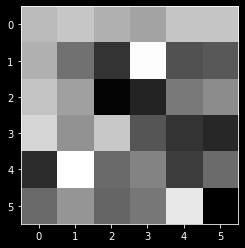

In [122]:
plt.imshow(pca.components_,cmap='gray')

#### Component Inter-Correlation Visualization

The following plots represent component inter-correlation merely after reshaping and scaling the array data.

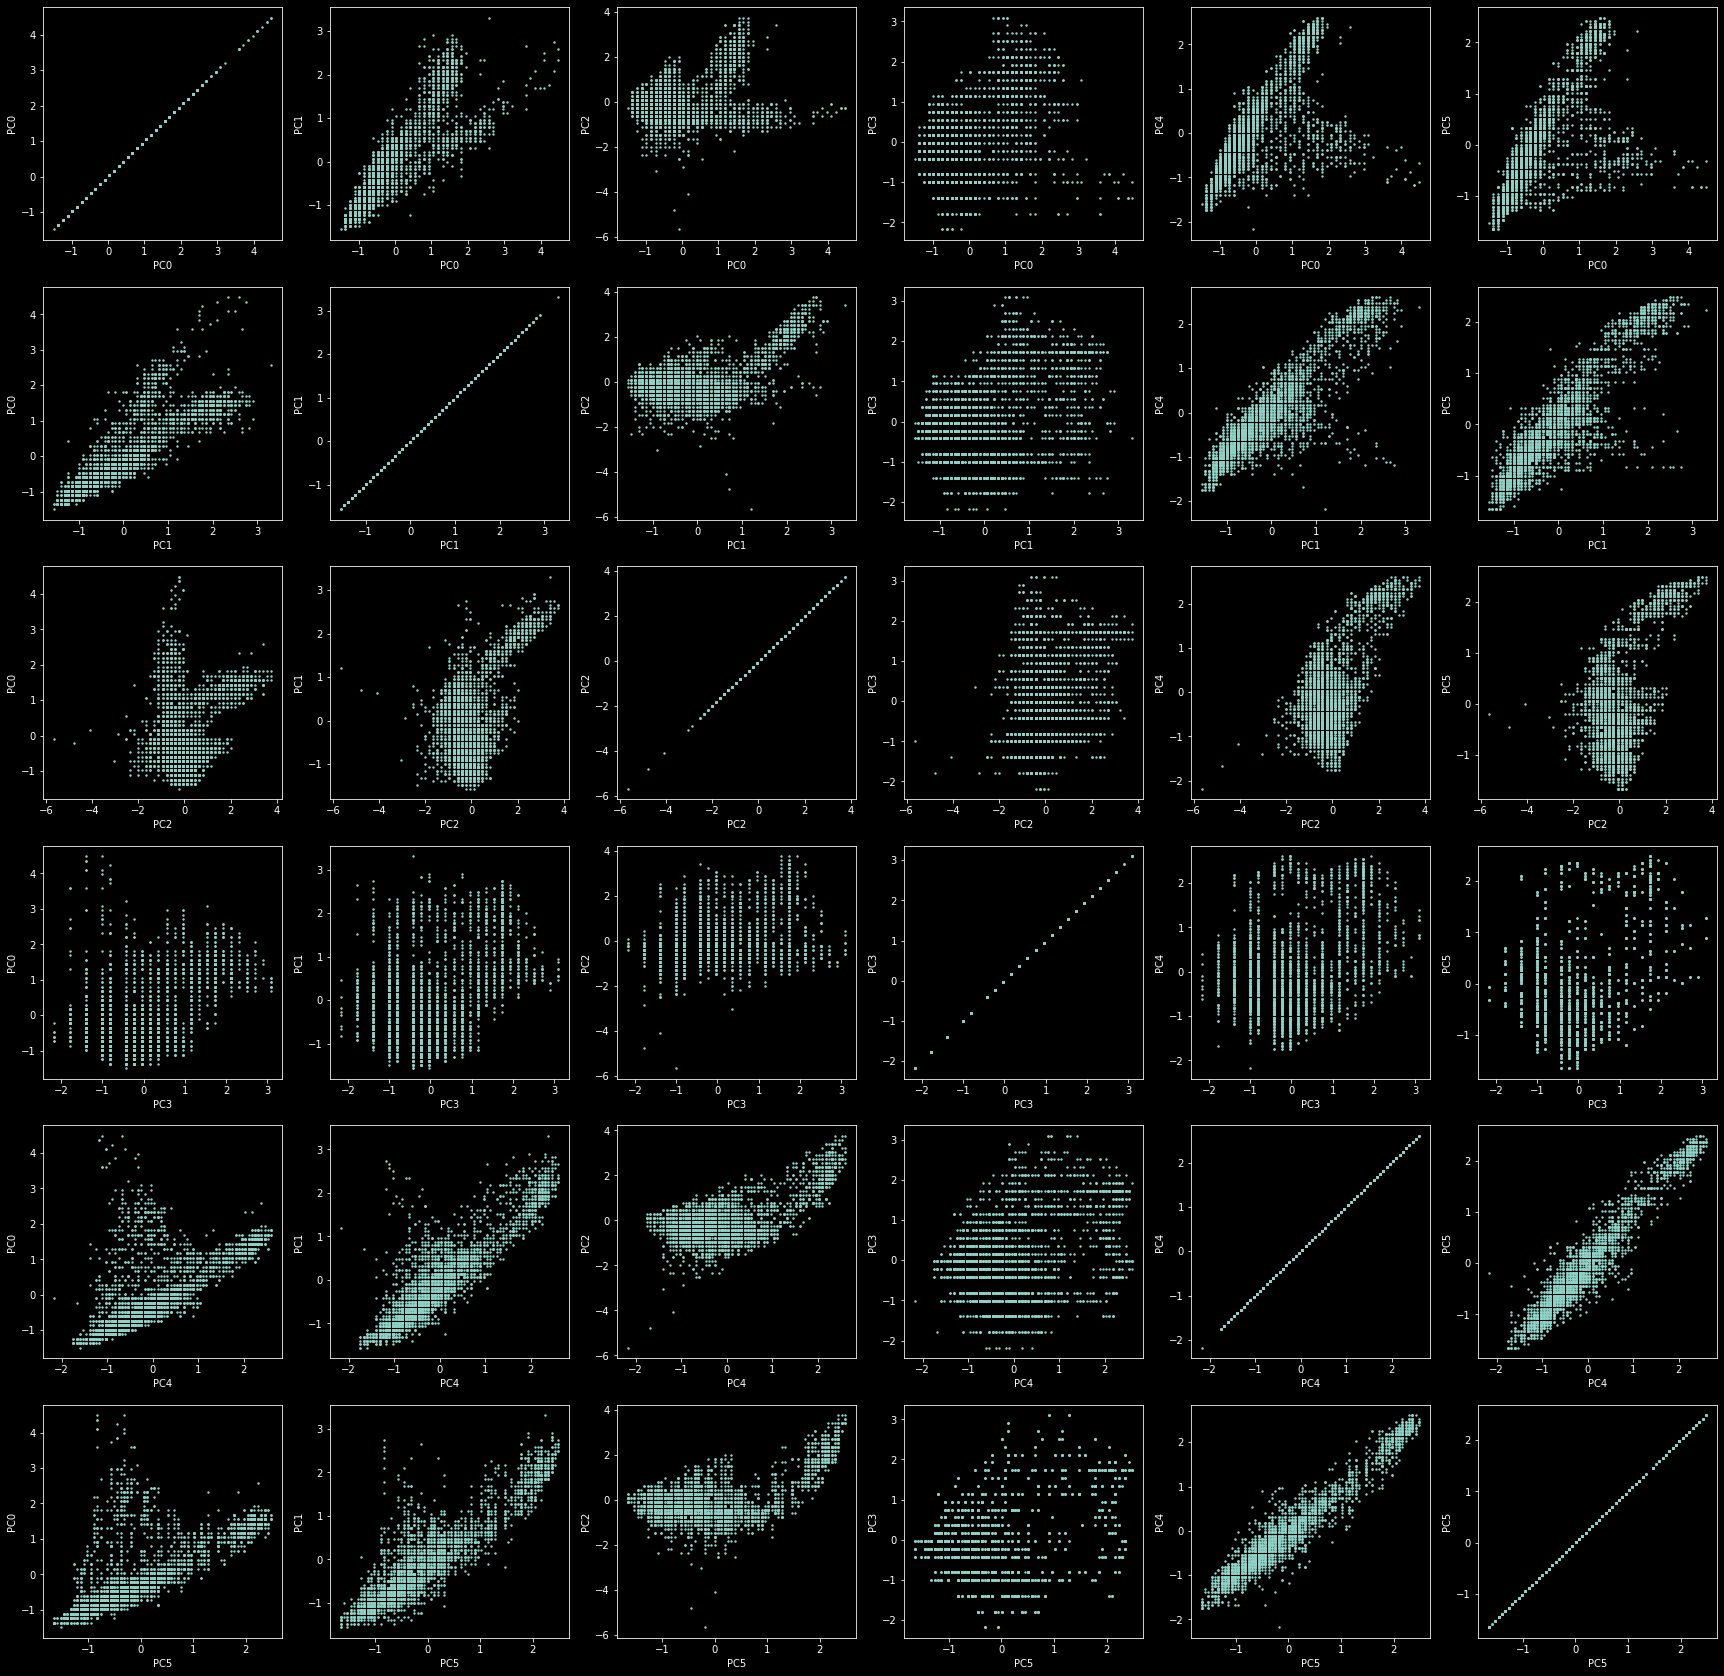

In [123]:
plt.style.use('dark_background')
figx,axx = plt.subplots(6,6,figsize=(30,30))
for i in range(0,6):
  for j in range(0,6):
    axx[i][j].scatter(X[:, i], X[:, j],s=2)
    axx[i][j].set_xlabel(f"PC{i}")
    axx[i][j].set_ylabel(f"PC{j}")
plt.show()

The following represents component inter-correlation after Principal Component Analysis via Singular Value Decomposition.

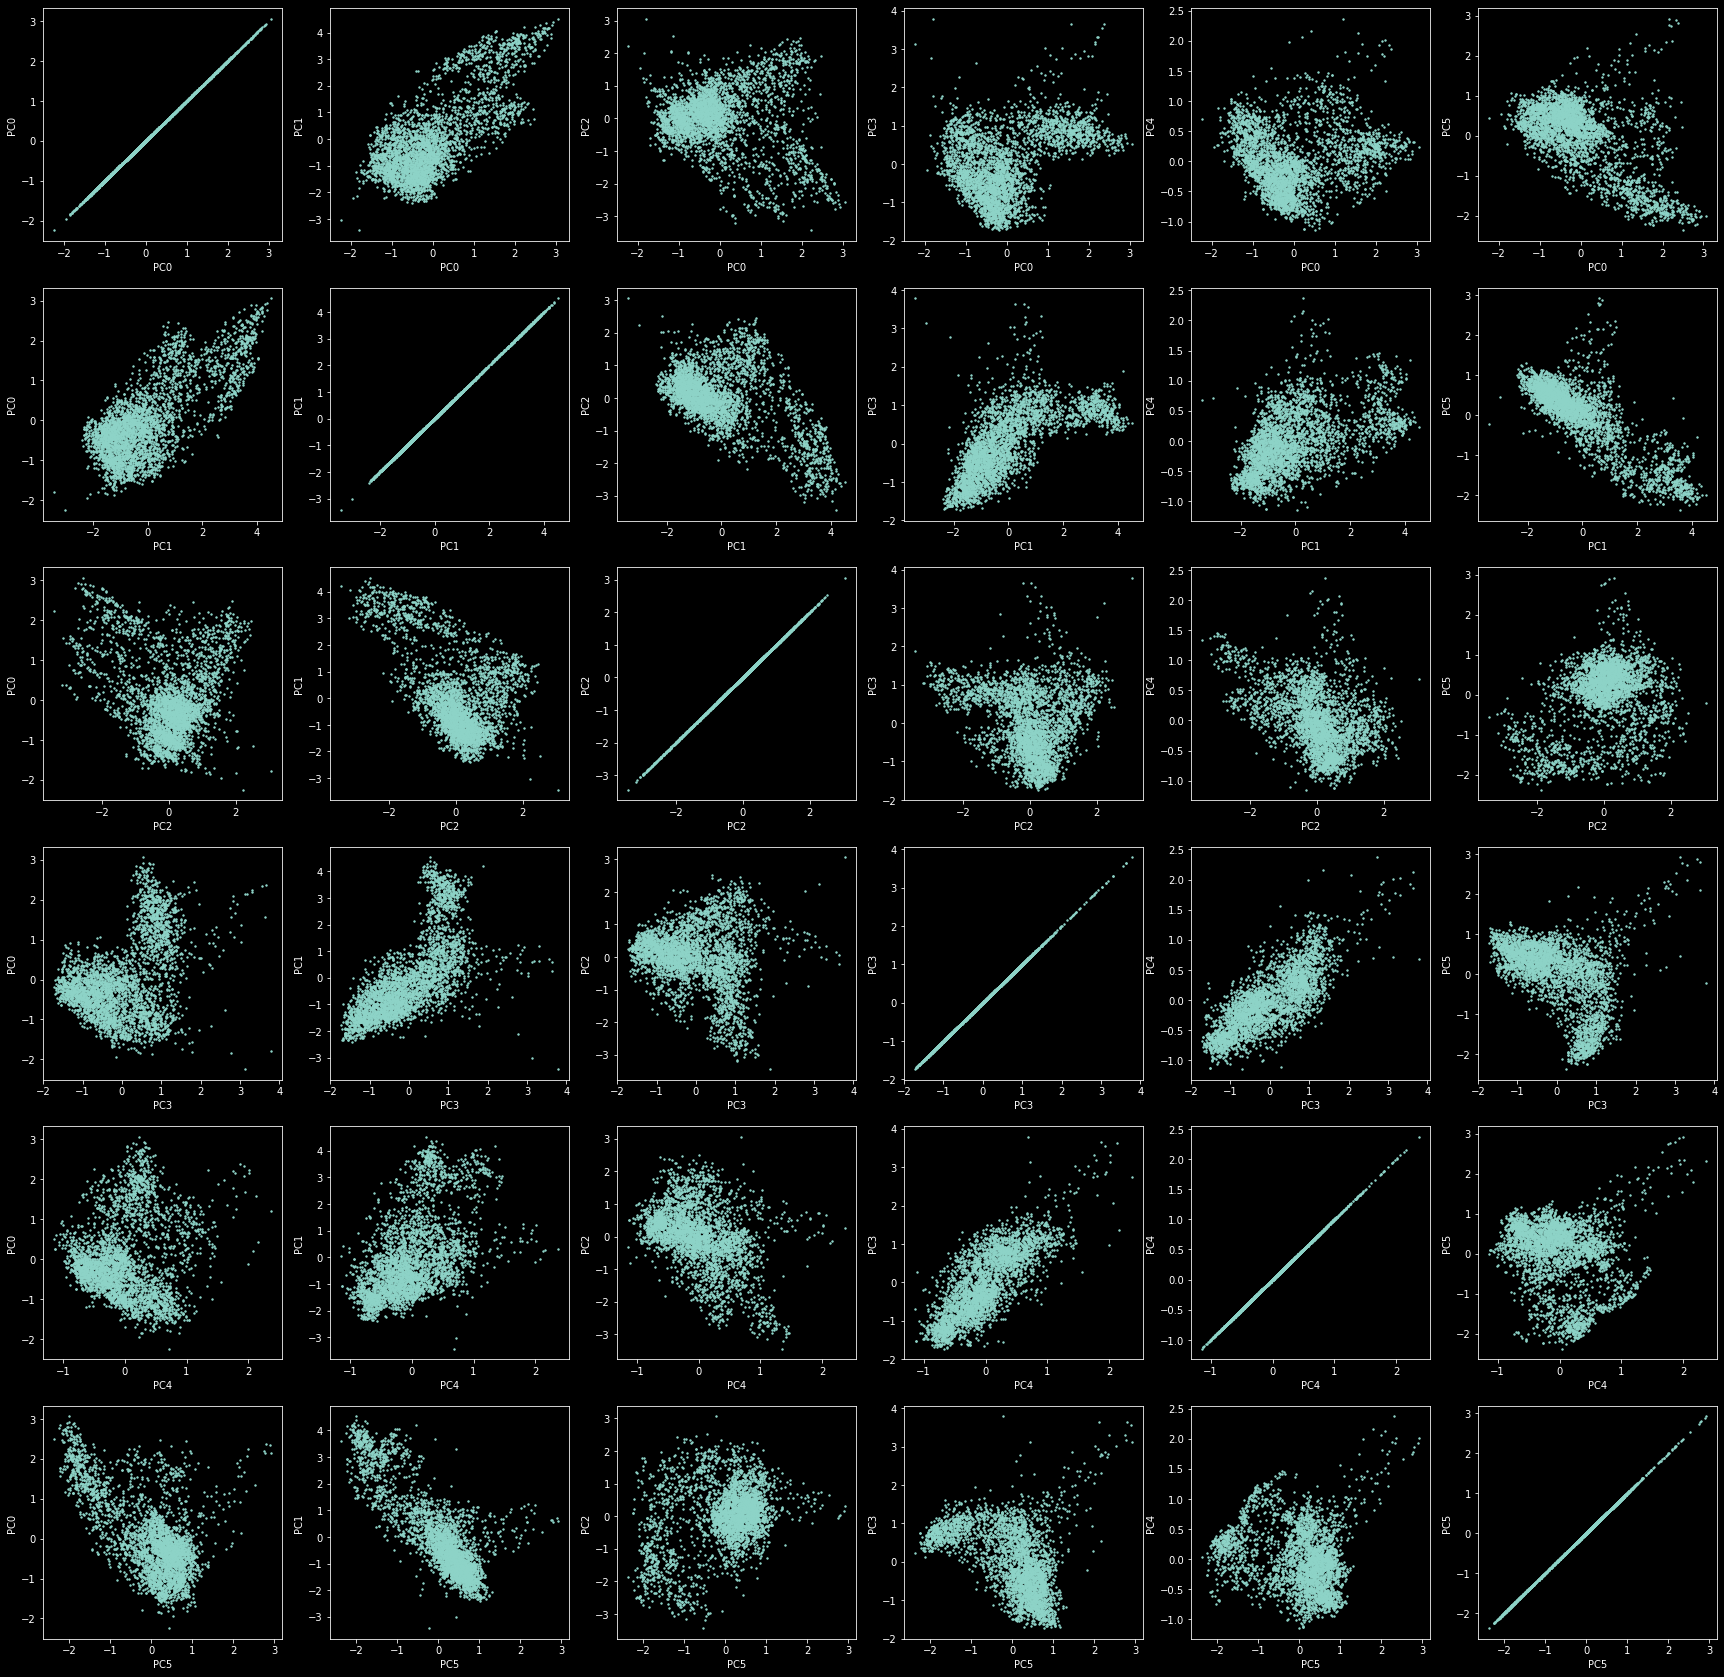

In [124]:
plt.style.use('dark_background')
fig,ax = plt.subplots(6,6,figsize=(30,30))
for i in range(0,6):
  for j in range(0,6):
    ax[i][j].scatter(X_pca[:, i], X_pca[:, j],s=2)
    ax[i][j].set_xlabel(f"PC{i}")
    ax[i][j].set_ylabel(f"PC{j}")
plt.show()

# Model Pipeline

In [ ]:
#U-Net Model
try:
    inputs = tf.keras.layers.Input((256, 256,1))
    s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)
    #Contraction Path
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = tf.keras.layers.Dropout(0.1)(c1)
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = tf.keras.layers.Dropout(0.1)(c2)
    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
    
    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = tf.keras.layers.Dropout(0.2)(c3)
    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
    
    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = tf.keras.layers.Dropout(0.2)(c4)
    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
    
    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = tf.keras.layers.Dropout(0.3)(c5)
    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    #Expansion Path 
    u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = tf.keras.layers.Dropout(0.2)(c6)
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
    
    u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = tf.keras.layers.Dropout(0.2)(c7)
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
    
    u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = tf.keras.layers.Dropout(0.1)(c8)
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
    
    u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = tf.keras.layers.Dropout(0.1)(c9)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = tf.keras.layers.Conv2D(3, (1, 1), activation='softmax')(c9)

    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
except Exception as e:
    exc_type, exc_obj, exc_tb = sys.exc_info()
    ble = os.path.split(exc_tb.tb_frame.f_code.co_filename)[1]
    print(exc_type, ble,"\n\nFound at Line",exc_tb.tb_lineno)
    print("\n\n⚠ ⚠ ⚠ ⚠\n\n",traceback.format_exc(),"\n⚠ ⚠ ⚠ ⚠")

In [ ]:
xtrain,xtest,ytrain,ytest=train_test_split(Xpy,Ypy,test_size=0.2,random_state=5)

In [ ]:
model.fit(xtrain[0:100],ytrain[0:100])
#Data Cardinality is Ambiguous